In [1]:
# Here we load probability points from saved pickle files. To fully recompute the results, see recompute.ipynb
import pickle as pkl
with open("data/lb.pkl", "rb") as f:
    lbounds_ped, points_ped, tpped_vals = pkl.load(f)
f.close()

with open("data/lbobj.pkl", "rb") as f:
    lbounds_obj, points_obj, tpobj_vals = pkl.load(f)
f.close()

with open("data/lbempty.pkl", "rb") as f:
    lbounds_emp, points_emp, tpemp_vals = pkl.load(f)
f.close()

In [2]:

from pacti.terms.polyhedra import PolyhedralContract
from pacti_counters import PactiInstrumentationData, PactiInstrumentationSummary, summarize_instrumentation_data

In [3]:


# First we construct each contract individually, and then merge the controller contract:
## Control contract for pedestrian class
def control_contract_ped(lbounds_ped, lbound_tp: float) -> PolyhedralContract:
    lb_m, lb_c = lbounds_ped
    tp = "tp_ped"
    P = "P_ped"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= {lbound_tp}"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cped = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cped



def control_contract_obj(lbounds_obj, lbound_tp: float) -> PolyhedralContract:
    lb_m, lb_c = lbounds_obj

    tp = "tp_obj"
    P = "P_obj"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= {lbound_tp}"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cobj = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cobj



def control_contract_emp(lbounds_emp, lbound_tp: float) -> PolyhedralContract:
    lb_m, lb_c = lbounds_emp

    tp = "tp_emp"
    P = "P_emp"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= {lbound_tp}"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cemp = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cemp


def generate_C_controller(
    lbounds_ped, ped_lbound_tp: float, 
    lbounds_obj, obj_lbound_tp: float, 
    lbounds_emp, emp_lbound_tp: float
) -> PolyhedralContract:
    Cped = control_contract_ped(lbounds_ped, ped_lbound_tp)
    Cobj = control_contract_obj(lbounds_obj, obj_lbound_tp)
    Cemp = control_contract_emp(lbounds_emp, emp_lbound_tp)
    return Cped.merge(Cobj).merge(Cemp)


For system contract, ensure that m*d + c in [0,1]

In [4]:
def check_probability_range(m: float, c: float, d_min: float, d_delta: float) -> None:
    p_min = m*d_min + c
    p_max = m*(d_min + d_delta) + c
    if not (0 <= p_min and p_min <= 1 and 0 <= p_max and p_max <= 1):
        raise ValueError(f"check failed: m={m}, d=[{d_min},{d_min+d_delta}], c={c} => p=[{p_min},{p_max}]")

def check_system_contract_dist(
    ped_lbound_tp: float, 
    obj_lbound_tp: float, 
    emp_lbound_tp: float,
    m_ped: float, c_ped: float,
    m_obj: float, c_obj: float,
    m_emp: float, c_emp: float,
    d_min: float, d_delta: float,
) -> bool:
    try:
        check_probability_range(m_ped, c_ped, d_min, d_delta)
        check_probability_range(m_obj, c_obj, d_min, d_delta)
        check_probability_range(m_emp, c_emp, d_min, d_delta)
        return True
    except ValueError:
        return False

def system_contract_dist(
    m_ped: float, c_ped: float,
    m_obj: float, c_obj: float,
    m_emp: float, c_emp: float,
    d_min: float, d_delta: float,
) -> PolyhedralContract:
    assert d_min >= 0

    assert m_ped < 0
    assert m_obj < 0
    assert m_emp < 0

    assert c_ped > 0
    assert c_obj > 0
    assert c_emp > 0

    d = "d"
    P_emp = "P_emp"
    P_obj = "P_obj"
    P_ped = "P_ped"
    input_vars = [d]
    output_vars = [P_ped, P_obj, P_emp]
    assumptions = [
        f"-{d} <= {d_min}",
        f"{d} <= {d_delta}",
        ]

    guarantees = [
        f"-{P_ped} - {abs(m_ped)}{d} <= -{abs(c_ped)}",
        f"-{P_obj} - {abs(m_obj)}{d} <= -{abs(c_obj)}",
        f"-{P_emp} - {abs(m_emp)}{d} <= -{abs(c_emp)}",
        ]
    system_contract = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return system_contract

In [5]:
from typing import Optional, Tuple

def calculate_quotient(
    ped_lbound_tp: float, 
    obj_lbound_tp: float, 
    emp_lbound_tp: float,
    m_ped: float, c_ped: float,
    m_obj: float, c_obj: float,
    m_emp: float, c_emp: float,
    d_min: float, d_delta: float,
) -> Tuple[PactiInstrumentationData, Optional[PolyhedralContract]]:
    try:
        C_controller = generate_C_controller(
            lbounds_ped, ped_lbound_tp, 
            lbounds_obj, obj_lbound_tp,
            lbounds_emp, emp_lbound_tp)
        
        C_sys_dist = system_contract_dist(
            m_ped, c_ped,
            m_obj, c_obj,
            m_emp, c_emp,
            d_min, d_min+d_delta)
    
        return PactiInstrumentationData().update_counts(), C_sys_dist.quotient(C_controller)
    except ValueError:
        return PactiInstrumentationData().update_counts(), None

In [6]:
from cpuinfo import get_cpu_info
cpu_info = get_cpu_info()
cpu_info_message = f"{cpu_info['brand_raw']} @ {cpu_info['hz_advertised_friendly']} with up to {cpu_info['count']} threads."


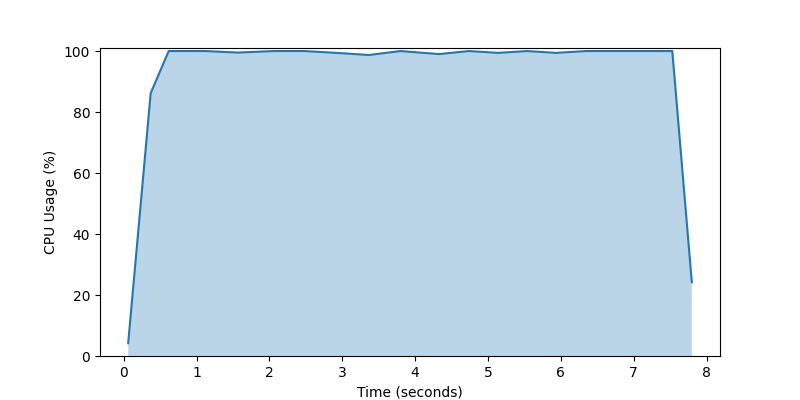

Output()

Found 1068 results out of 1068 filtered combinations from 100000 samples.
Total time 7.857940912246704 running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.
Pacti compose,quotient,merge statistics:
no compose operations
quotient invocation counts: (min: 0, max: 34, avg: 16.198501872659175, total: 17300)
min/max quotient contract size: (constraints: 5, variables: 4)/(constraints: 11, variables: 4)
merge invocation counts: (min: 2, max: 70, avg: 34.39700374531835, total: 36736)
min/max merge contract size: (constraints: 3, variables: 2)/(constraints: 9, variables: 6)
Pacti PolyhedralTermList statistics:
no contains_behavior operations
Pacti PolyhedralCompoundContract statistics:
no compound_merge operations



In [7]:
sample_l_bounds = [
    -0.9,   # ped_lbound_tp
    -0.9,   # obj_lbound_tp
    -0.9,   # emp_lbound_tp
    -0.3,   # m_ped
    0.2,    # c_ped
    -0.3,   # m_obj
    0.2,    # c_obj
    -0.3,   # m_emp
    0.2,    # c_emp
    0,      # d_min
    2,      # d_delta
]

sample_u_bounds = [
    -0.2,   # ped_lbound_tp
    -0.1,   # obj_lbound_tp
    -0.2,   # emp_lbound_tp
    -0.01,  # m_ped
    0.99,   # c_ped
    -0.01,  # m_obj
    0.99,   # c_obj
    -0.01,  # m_emp
    0.99,   # c_emp
    8,      # d_min
    15,     # d_delta
]

nb_samples = 100000

import numpy as np
from scipy.stats import qmc
sampler: qmc.LatinHypercube = qmc.LatinHypercube(d=len(sample_l_bounds))

unscaled_sample: np.ndarray = sampler.random(n=nb_samples)
scaled_sample: np.ndarray = qmc.scale(sample=unscaled_sample, l_bounds=sample_l_bounds, u_bounds=sample_u_bounds)
filtered_sample: np.ndarray = [sample for sample in scaled_sample if check_system_contract_dist(*sample)]
import time
from typing import List, Tuple
from p_tqdm import p_umap
from cpu_usage_plot import cpu_usage_plot

def calculate_quotient_params(params: Tuple[float]) -> Tuple[PactiInstrumentationData, Optional[PolyhedralContract]]:
    return calculate_quotient(*params)

with cpu_usage_plot(finally_clear_output=True):
    ta = time.time()
    results = p_umap(calculate_quotient_params, filtered_sample)
    tb = time.time()

stats = summarize_instrumentation_data([result[0] for result in results])
filtered_results = [result[1] for result in results if result[1]]

print(
    f"Found {len(filtered_results)} results out of {len(filtered_sample)} filtered combinations from {len(scaled_sample)} samples.\n"
    f"Total time {tb-ta} running on {cpu_info_message}\n"
    f"{stats.stats()}"
)